In [731]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report

Notes:
- Make the "skills" be a true/false
- Try another version of the model which has bands, perhaps instead of seniority or exp

In [732]:
# -------------------
# Load and clean data
# -------------------
df = pd.read_csv("/Users/erikborn/Documents/Python/jupyter/Salary_ML/modelData3.csv")

# Clean numeric fields
df["25-26 Salary"] = pd.to_numeric(df["25-26 Salary"].str.replace(",", ""), errors="coerce")
df["Prep Rating"] = pd.to_numeric(df["Prep Rating"], errors="coerce")
df = df.dropna()

# 🕓 Recalculate Seniority based on Hire Date
df["Hire Date"] = pd.to_datetime(df["Hire Date"], errors="coerce")
df["Seniority"] = pd.Timestamp("2024-01-01").year - df["Hire Date"].dt.year

# 🔧 Recode Skill Rating to binary: 0 if == 3, 1 if > 3
df["Skill Rating"] = df["Skill Rating"].apply(lambda x: 1 if x > 3 else 0)

# 🎯 Create 5-year experience bands (0–5, 6–10, ..., 30+)
df["Experience Band"] = pd.cut(
    df["Years of Exp"],
    bins=[-1, 5, 10, 15, 20, 25, 30, 100],
    labels=["00-05", "06-10", "11-15", "16-20", "21-25", "26-30", "30+"]
)

# -------------------
# Features selection
# -------------------
features_to_keep = [
    "Years of Exp",
    "Seniority",
    "Skill Rating",
    "Prep Rating",
    "Knowledge Rating"
]

# One-hot encode categorical features, including new Experience Band
cats = [
    "Level",
    "Gender", 
    "Education Level",
    "Experience Band"
]
df_encoded = pd.get_dummies(df, columns=cats, drop_first=True)

# Identify the dummy feature columns
categorical_dummies = [col for col in df_encoded.columns if any(prefix in col for prefix in cats)]
features_to_use = features_to_keep + categorical_dummies

# Final X and y
X = df_encoded[features_to_use]
y = df_encoded["25-26 Salary"]

In [733]:
# ---------------------------
# Safe wrapper for RMSE
# ---------------------------
def safe_rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

rmse_scorer = make_scorer(safe_rmse, greater_is_better=False)

# ---------------------------
# Alpha tuning with CV
# ---------------------------
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=40)

ridge = Ridge()
alpha_grid = {'alpha': np.logspace(-2, 3, 20)}  # from 0.01 to 1000

# Run grid search
grid = GridSearchCV(
    estimator=ridge,
    param_grid=alpha_grid,
    scoring={"r2": "r2", "rmse": rmse_scorer},
    refit="r2",
    cv=rkf
)

grid.fit(X, y)

# Extract scores
cv_results = grid.cv_results_
best_alpha = grid.best_params_['alpha']

mean_r2 = grid.best_score_
std_r2 = cv_results["std_test_r2"][grid.best_index_]
mean_rmse = -cv_results["mean_test_rmse"][grid.best_index_]  # flip sign
std_rmse = cv_results["std_test_rmse"][grid.best_index_]

# ---------------------------
# Display
# ---------------------------
print("\n🧪 Ridge Regression Cross-Validation with Alpha Tuning:")
print("Best Alpha\tAvg R²\t\tStd R²\t\tAvg RMSE\t\tStd RMSE")
print(f"{best_alpha:<10.4f}\t{mean_r2:.4f}\t\t{std_r2:.4f}\t\t{mean_rmse:,.2f}\t\t{std_rmse:,.2f}")


🧪 Ridge Regression Cross-Validation with Alpha Tuning:
Best Alpha	Avg R²		Std R²		Avg RMSE		Std RMSE
14.3845   	0.6092		0.1683		5,971.98		1,123.42


In [734]:
# -------------------
# Outlier detection
# -------------------
model_noOuts.fit(X, y)
df["Prediction"] = model_noOuts.predict(X)
df["Residual"] = df["25-26 Salary"] - df["Prediction"]

# Control outlier threshold as a percent of actual salary
threshold_percent = 0.05
df["Outlier_Flag"] = df["Residual"].abs() > (threshold_percent * df["25-26 Salary"])

# -------------------
# Train classifier to identify outliers
# -------------------
X_class = X.copy()
y_class = df["Outlier_Flag"]

X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

probs = clf.predict_proba(X_test)[:, 1]
y_custom = probs > 0.3

print("\n📊 Outlier Classifier Performance (custom threshold):")
print(classification_report(y_test, y_custom))


📊 Outlier Classifier Performance (custom threshold):
              precision    recall  f1-score   support

       False       0.60      0.60      0.60        10
        True       0.20      0.20      0.20         5

    accuracy                           0.47        15
   macro avg       0.40      0.40      0.40        15
weighted avg       0.47      0.47      0.47        15



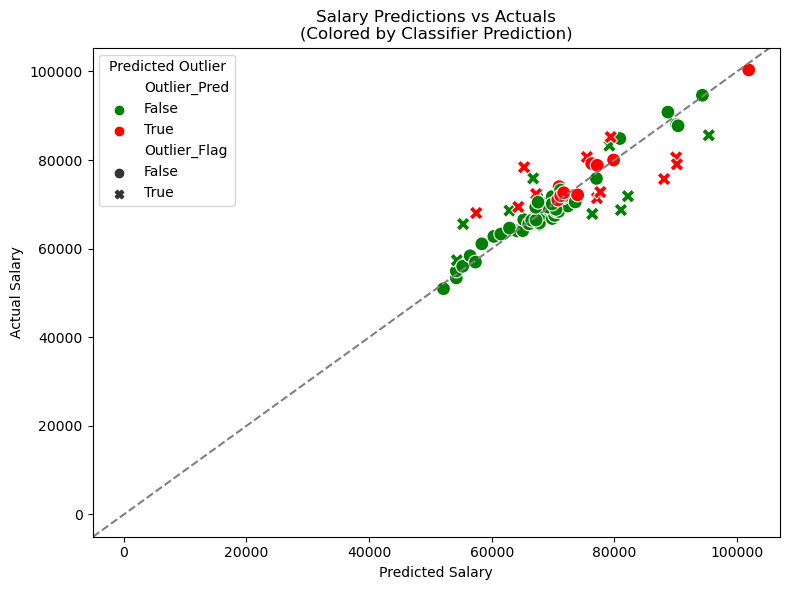

In [735]:
# -------------------
# Visualization
# -------------------
df["Outlier_Prob"] = clf.predict_proba(X_class)[:, 1]
df["Outlier_Pred"] = df["Outlier_Prob"] > 0.4

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="25-26 Salary",
    y="Prediction",
    hue="Outlier_Pred",
    palette={True: "red", False: "green"},
    style="Outlier_Flag",
    markers={True: "X", False: "o"},
    s=100
)
plt.axline((0, 0), slope=1, linestyle="--", color="gray")
plt.title("Salary Predictions vs Actuals\n(Colored by Classifier Prediction)")
plt.xlabel("Predicted Salary")
plt.ylabel("Actual Salary")
plt.legend(title="Predicted Outlier")
plt.tight_layout()
plt.show()

In [736]:
from sklearn.model_selection import RepeatedKFold, cross_validate

# Filter to only rows *not* flagged as outliers
df_clean = df[~df["Outlier_Flag"]].copy()

# Match index of rows not flagged as outliers
clean_indices = df_clean.index

# Ensure we use the same features as original X
features_to_use = X.columns.tolist()

# Rebuild X and y using just those rows and the exact same features
X_clean = df_encoded.loc[clean_indices, features_to_use]
y_clean = df.loc[clean_indices, "25-26 Salary"]

# Set up repeated cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=25, random_state=41)

# Ridge model (alpha = 1)
a = 1
model_noOuts = Ridge(alpha=a)

# Run CV
scores = cross_validate(
    model_noOuts,
    X_clean,
    y_clean,
    cv=rkf,
    scoring=('r2', 'neg_mean_squared_error'),
    return_train_score=False
)

# Analyze results
r2_scores = scores["test_r2"]
rmse_scores = (-scores["test_neg_mean_squared_error"]) ** 0.5

# Display
print("\n🧪 Ridge Regression Cross-Validation (Excluding Outliers):")
print(f"Used {len(X_clean):,} data points for training after outlier exclusion.\n")
print("Alpha\tAvg R²\t\tStd R²\t\tAvg RMSE\t\tStd RMSE")
print(f"{a:<6}\t{np.mean(r2_scores):.4f}\t\t{np.std(r2_scores):.4f}\t\t{np.mean(rmse_scores):,.2f}\t\t{np.std(rmse_scores):,.2f}")


🧪 Ridge Regression Cross-Validation (Excluding Outliers):
Used 54 data points for training after outlier exclusion.

Alpha	Avg R²		Std R²		Avg RMSE		Std RMSE
1     	0.9485		0.0423		1,766.31		338.31


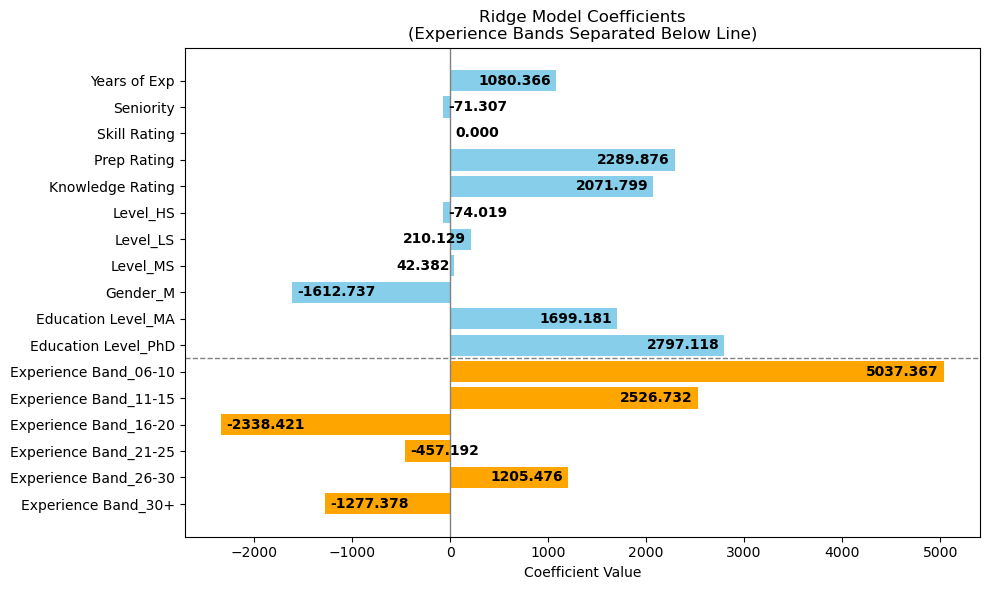

In [737]:
import matplotlib.pyplot as plt

# Fit the model on cleaned data (if not already done)
model_noOuts = Ridge(alpha=1.0)
model_noOuts.fit(X_clean, y_clean)

# Get coefficients into a DataFrame
coef_df = pd.DataFrame({
    "Feature": X_clean.columns,
    "Coefficient": model_noOuts.coef_
})

# Separate experience band features
band_features = [col for col in coef_df["Feature"] if "Experience Band_" in col]
non_band_df = coef_df[~coef_df["Feature"].isin(band_features)].copy()
band_df = coef_df[coef_df["Feature"].isin(band_features)].copy()

# Combine with non-band features on top (no sorting)
coef_df_ordered = pd.concat([non_band_df, band_df], axis=0)

# Color coding: orange for bands, blue for others
colors = ["orange" if "Experience Band_" in feat else "skyblue" for feat in coef_df_ordered["Feature"]]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(coef_df_ordered["Feature"], coef_df_ordered["Coefficient"], color=colors)

# Add coefficient values to bars
for bar, coef in zip(bars, coef_df_ordered["Coefficient"]):
    width = bar.get_width()
    text = f"{coef:.3f}"
    xpos = width - 0.01 * max(abs(coef_df_ordered["Coefficient"])) if width > 0 else width + 0.01 * max(abs(coef_df_ordered["Coefficient"]))
    align = "right" if width > 0 else "left"
    plt.text(
        xpos,
        bar.get_y() + bar.get_height() / 2,
        text,
        va="center",
        ha=align,
        color="black",
        fontweight="bold"
    )

# Add vertical zero line
plt.axvline(0, color="gray", linewidth=1)

# Draw separator between non-band and band features
sep_index = len(non_band_df)
plt.axhline(y=sep_index - 0.5, color="gray", linestyle="--", linewidth=1)

# Title and axis labels
plt.title("Ridge Model Coefficients\n(Experience Bands Separated Below Line)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

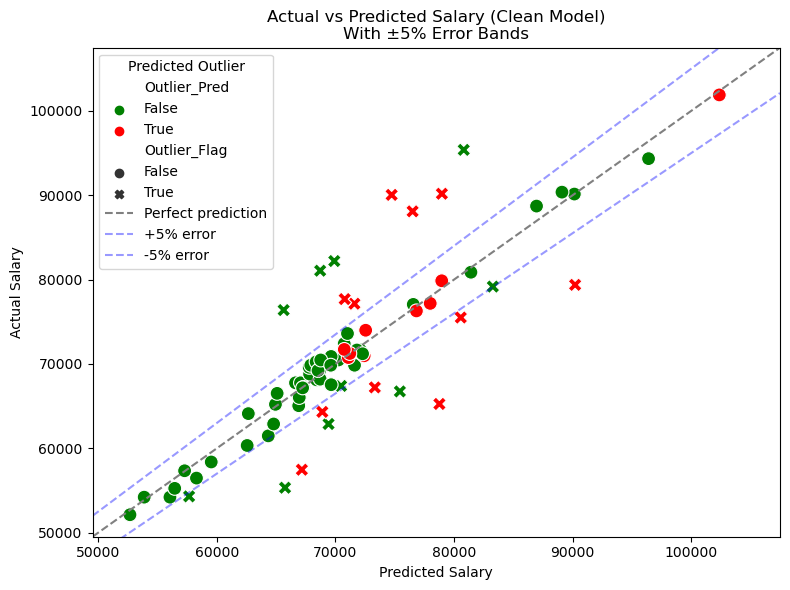

In [738]:
# Predict using the clean model
X_predict = df_encoded[model_noOuts.feature_names_in_]
df["Prediction_from_clean_model"] = model_noOuts.predict(X_predict)

# Plot setup
plt.figure(figsize=(8, 6))

# Scatterplot: color = predicted outlier, shape = true outlier
sns.scatterplot(
    data=df,
    x="Prediction_from_clean_model",
    y="25-26 Salary",
    hue="Outlier_Pred",
    style="Outlier_Flag",
    palette={True: "red", False: "green"},
    markers={True: "X", False: "o"},
    s=100
)

# Reference lines
lims = [
    min(df["25-26 Salary"].min(), df["Prediction_from_clean_model"].min()) * 0.95,
    max(df["25-26 Salary"].max(), df["Prediction_from_clean_model"].max()) * 1.05,
]

x_vals = np.linspace(lims[0], lims[1], 100)
plt.plot(x_vals, x_vals, "--", color="gray", label="Perfect prediction")
plt.plot(x_vals, x_vals * 1.05, "--", color="blue", alpha=0.4, label="+5% error")
plt.plot(x_vals, x_vals * 0.95, "--", color="blue", alpha=0.4, label="-5% error")

# Labels and layout
plt.title("Actual vs Predicted Salary (Clean Model)\nWith ±5% Error Bands")
plt.xlabel("Predicted Salary")
plt.ylabel("Actual Salary")
plt.xlim(lims)
plt.ylim(lims)
plt.legend(title="Predicted Outlier")
plt.tight_layout()
plt.show()

In [739]:
# Calculate residual info (if not already done)
df["Residual"] = df["25-26 Salary"] - df["Prediction_from_clean_model"]
df["Residual %"] = df["Residual"] / df["25-26 Salary"]
df["Residual % (abs)"] = df["Residual %"].abs() * 100  # for display
df["Outlier_Pred_Label"] = df["Outlier_Pred"].map({True: "Flagged", False: "Normal"})
df["Outlier_True_Label"] = df["Outlier_Flag"].map({True: "Actual Outlier", False: "Not Outlier"})

# Optional: dummy label for anonymity
df["Label"] = df.index.astype(str)

# Base plot
fig = px.scatter(
    df,
    x="Prediction_from_clean_model",
    y="25-26 Salary",
    color="Outlier_Pred_Label",
    symbol="Outlier_True_Label",
    hover_data={
        "Employee": True,
        "ID": True,
        "25-26 Salary": ":,.0f",
        "Prediction_from_clean_model": ":,.0f",
        "Residual": ":,.0f",
        "Residual % (abs)": ":.1f"
    },
    labels={
        "Prediction_from_clean_model": "Predicted Salary",
        "25-26 Salary": "Actual Salary"
    },
    title="Interactive Prediction vs Actual Salary"
)

# Add ±5% error lines
lims = [
    min(df["25-26 Salary"].min(), df["Prediction_from_clean_model"].min()) * 0.95,
    max(df["25-26 Salary"].max(), df["Prediction_from_clean_model"].max()) * 1.05,
]
x_vals = np.linspace(lims[0], lims[1], 100)

fig.add_scatter(
    x=x_vals, y=x_vals,
    mode='lines', line=dict(dash='dash', color='gray'),
    name='Perfect Prediction'
)
fig.add_scatter(
    x=x_vals, y=x_vals * 1.05,
    mode='lines', line=dict(dash='dot', color='blue'),
    name='+5% Error'
)
fig.add_scatter(
    x=x_vals, y=x_vals * 0.95,
    mode='lines', line=dict(dash='dot', color='blue'),
    name='-5% Error'
)

# Final layout
fig.update_layout(
    xaxis_title="Predicted Salary",
    yaxis_title="Actual Salary",
    legend_title="Predicted Outlier",
    width=900,
    height=600
)

fig.show()

In [740]:
# --------------------------------------------
# Top largest residuals (actual vs predicted)
# --------------------------------------------

# Ensure residuals are computed
df["Residual"] = df["25-26 Salary"] - df["Prediction_from_clean_model"]
df["Residual %"] = (df["Residual"] / df["25-26 Salary"]).abs()

# Sort by absolute residual percentage
top_residuals = df.sort_values("Residual %", ascending=False).copy()

# Choose how many you want to display
n = 10

# Format numeric columns with commas (no decimals)
top_residuals["25-26 Salary (formatted)"] = top_residuals["25-26 Salary"].apply(lambda x: f"{int(round(x)):,}")
top_residuals["Predicted Salary (formatted)"] = top_residuals["Prediction_from_clean_model"].apply(lambda x: f"{int(round(x)):,}")
top_residuals["Residual (formatted)"] = top_residuals["Residual"].apply(lambda x: f"{int(round(x)):,}")
top_residuals["Residual % (formatted)"] = top_residuals["Residual %"].apply(lambda x: f"{x*100:.1f}%")

# Columns to show
display_cols = [
    "Employee",
    "ID",
    "25-26 Salary (formatted)",
    "Predicted Salary (formatted)",
    "Residual (formatted)",
    "Residual % (formatted)",
    "Outlier_Flag",
    "Outlier_Pred",
    "Outlier_Prob"
]

# Show top n
top_residuals[display_cols].head(n)

,Employee,ID,25-26 Salary (formatted),Predicted Salary (formatted),Residual (formatted),Residual % (formatted),Outlier_Flag,Outlier_Pred,Outlier_Prob
62,"Hon, Rebecca M",3245.0,"65,259","78,766","-13,507",20.7%,True,True,0.519673
11,"Von Tscharner, Emma M",3161.0,"55,328","65,752","-10,424",18.8%,True,False,0.052443
61,"Johnson, Marie F",3108.0,"90,045","74,743","15,302",17.0%,True,True,0.481390
46,"Turnbull, Jennie",3033.0,"57,463","67,170","-9,707",16.9%,True,True,0.427841
71,"Gentry, Phillip M",1092.0,"95,382","80,822","14,560",15.3%,True,False,0.256276
45,"LaRocque, Carol A",3191.0,"81,055","68,714","12,341",15.2%,True,False,0.139560
60,"Hill, Bettye",3151.0,"82,201","69,904","12,297",15.0%,True,False,0.261357
32,"McHugh, John N",3285.0,"76,387","65,638","10,749",14.1%,True,False,0.107878
73,"Otto, Theresa J",3195.0,"79,378","90,212","-10,834",13.6%,True,True,0.509403
67,"Barton, Sarah F",3303.0,"88,090","76,509","11,581",13.1%,True,True,0.703249


In [741]:
# Choose row index from original dataset
target_index = 25  # Must be a valid index in df

# Lookup employee info
employee_name = df.loc[target_index, "Employee"]
employee_id = df.loc[target_index, "ID"]
employee_salary = df.loc[target_index, "25-26 Salary"]

# Extract the row for explanation
x_target = X.loc[[target_index]]  # As a DataFrame

# ---------------------------
# Set up custom baseline
# ---------------------------
# Use average row as base, then zero out experience fields
reference_row = X.mean().to_frame().T  # one-row DataFrame
if "Years of Exp" in reference_row.columns:
    reference_row["Years of Exp"] = 0
if "Years Since Hire" in reference_row.columns:
    reference_row["Years Since Hire"] = 0

# Use this reference row for the SHAP explainer
explainer = shap.KernelExplainer(model_noOuts.predict, reference_row)

# Compute SHAP values for this person
shap_values = explainer.shap_values(x_target)

# ---------------------------
# Build the explanation
# ---------------------------
shap_df = pd.DataFrame({
    "Feature": x_target.columns,
    "Value": x_target.iloc[0].values,
    "SHAP Impact": shap_values[0]
}).sort_values("SHAP Impact", key=abs, ascending=False)

shap_df["Direction"] = shap_df["SHAP Impact"].apply(lambda x: "↑ raises" if x > 0 else "↓ lowers")
shap_df["SHAP Impact"] = shap_df["SHAP Impact"].map(lambda x: f"{x:,.0f}")

# ---------------------------
# Display it
# ---------------------------
print(f"📌 SHAP Breakdown for Index {target_index}")
print(f"👤 Employee: {employee_name} (ID: {int(employee_id)})")
print(f"Predicted Salary: ${model_noOuts.predict(x_target)[0]:,.0f}")
print(f"Actual Salary:    ${employee_salary:,.0f}")
print(f"Baseline (0-Exp) Prediction: ${explainer.expected_value:,.0f}\n")
print(shap_df[["Feature", "Value", "SHAP Impact", "Direction"]].head(12).to_string(index=False))

  0%|          | 0/1 [00:00<?, ?it/s]

📌 SHAP Breakdown for Index 25
👤 Employee: Passin, Laura E (ID: 3248)
Predicted Salary: $67,789
Actual Salary:    $69,603
Baseline (0-Exp) Prediction: $55,102

              Feature Value SHAP Impact Direction
         Years of Exp     7       7,559  ↑ raises
Experience Band_06-10  True       3,565  ↑ raises
  Education Level_PhD  True       2,684  ↑ raises
   Education Level_MA False      -1,115  ↓ lowers
Experience Band_16-20 False         499  ↑ raises
Experience Band_11-15 False        -409  ↓ lowers
          Prep Rating     0        -400  ↓ lowers
             Gender_M False         379  ↑ raises
     Knowledge Rating   0.3        -324  ↓ lowers
            Seniority     4         249  ↑ raises
             Level_MS False           0  ↓ lowers
             Level_LS False           0  ↓ lowers


In [742]:
# Set the original index from df (can be anything in df)
original_index = target_index  # 👈 change this to whichever row you want to explain

# Make sure that row exists
if original_index not in df_encoded.index:
    raise ValueError(f"Index {original_index} not found in original data!")

# Match exact features used for training
x_target = df_encoded.loc[[original_index], X_clean.columns]

# SHAP: Use KernelExplainer (you already fit model_noOuts earlier)
explainer = shap.KernelExplainer(model_noOuts.predict, X_clean)
shap_values = explainer.shap_values(x_target)

# Create SHAP DataFrame for display
shap_df = pd.DataFrame({
    "Feature": x_target.columns,
    "Value": x_target.iloc[0].values,
    "SHAP Impact": shap_values[0]
})
shap_df["Abs Impact"] = shap_df["SHAP Impact"].abs()
shap_df["Impact Direction"] = shap_df["SHAP Impact"].apply(lambda x: "Raises Prediction" if x > 0 else "Lowers Prediction")
shap_df = shap_df.sort_values("Abs Impact", ascending=True)

baseline = float(explainer.expected_value)  # ensure it's a plain number
title = (
    f"🔍 SHAP Explanation for Index {original_index}<br>"
    f"Predicted: ${model_noOuts.predict(x_target)[0]:,.0f} | "
    f"Baseline: ${baseline:,.0f}"
)

# Interactive plot
fig = px.bar(
    shap_df,
    x="SHAP Impact",
    y="Feature",
    orientation="h",
    color="Impact Direction",
    hover_data={
        "Value": True,
        "SHAP Impact": True,
        "Feature": False,
        "Impact Direction": False
    },
    title=title,
    color_discrete_map={
        "Raises Prediction": "green",
        "Lowers Prediction": "red"
    }
)

fig.update_layout(
    xaxis_title="SHAP Impact on Prediction",
    yaxis_title="Feature",
    height=500
)

fig.show()

  0%|          | 0/1 [00:00<?, ?it/s]

In [743]:
# Prepare HR export DataFrame
hr_export = df.copy()

# Format numeric columns
hr_export["Predicted Salary"] = df["Prediction_from_clean_model"].round(0)
hr_export["Residual"] = (df["25-26 Salary"] - df["Prediction_from_clean_model"]).round(0)
hr_export["Residual %"] = ((hr_export["Residual"] / df["25-26 Salary"]) * 100).round(1)

# Flag columns
hr_export["Recommended for Review"] = df["Outlier_Pred"]
hr_export["Actual Outlier"] = df["Outlier_Flag"]
hr_export["Model Confidence (Outlier %)"] = (df["Outlier_Prob"] * 100).round(1)

# Optional: reformat currency-style columns for HR readability
for col in ["25-26 Salary", "Predicted Salary", "Residual"]:
    hr_export[col] = hr_export[col].apply(lambda x: f"${int(x):,}" if pd.notnull(x) else "")

# Reorder columns to put ID and Employee first, then key model columns
id_columns = ["Employee", "ID"]
key_columns = [
    "25-26 Salary", "Predicted Salary", "Residual", "Residual %"
]
other_columns = [col for col in hr_export.columns if col not in id_columns + key_columns]
hr_export = hr_export[id_columns + key_columns + other_columns]

# Sort by % error: lowest residuals (underpaid) at top
hr_export_sorted = hr_export.sort_values("Residual %")

# Export
hr_export_sorted.to_csv("salary_model_output_for_HR_sorted.csv", index=False)

print("✅ Exported: 'salary_model_output_for_HR_sorted.csv' (sorted by Residual %) with Employee and ID first")

✅ Exported: 'salary_model_output_for_HR_sorted.csv' (sorted by Residual %) with Employee and ID first


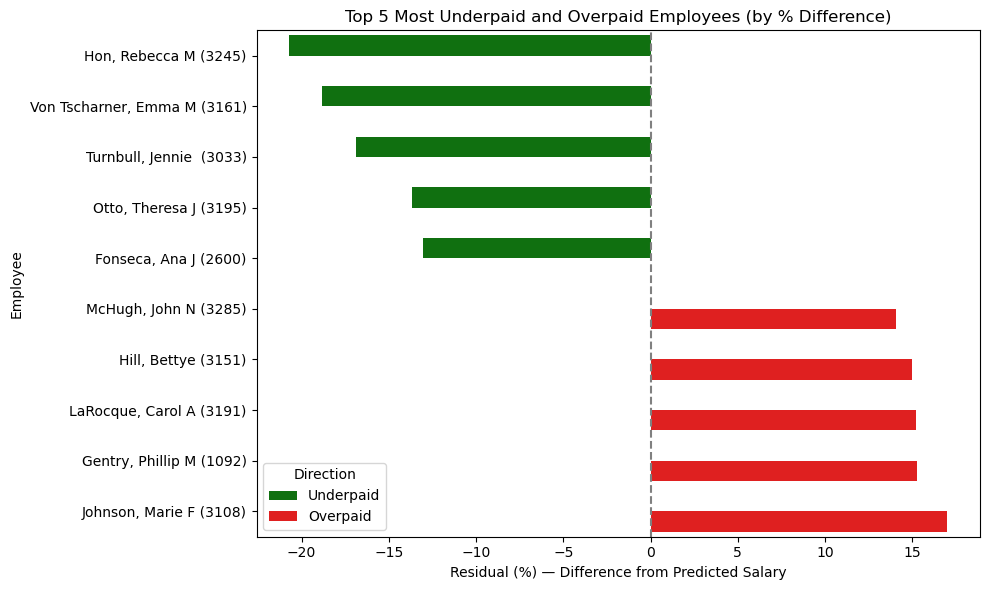

In [744]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a working copy
df_viz = df.copy()

# Calculate numeric residual % (if not already done)
df_viz["Residual %"] = (
    (df_viz["25-26 Salary"] - df_viz["Prediction_from_clean_model"]) / df_viz["25-26 Salary"]
) * 100

# Get top 5 underpaid and overpaid employees by percent
top_5 = df_viz.nsmallest(5, "Residual %")  # most underpaid
bottom_5 = df_viz.nlargest(5, "Residual %")  # most overpaid
viz_df = pd.concat([top_5, bottom_5]).copy()

# Sort so the plot flows from most underpaid to most overpaid
viz_df = viz_df.sort_values("Residual %", ascending=True)

# Add labels
viz_df["Residual Direction"] = viz_df["Residual %"].apply(lambda x: "Overpaid" if x > 0 else "Underpaid")
viz_df["Employee Label"] = viz_df["Employee"] + " (" + viz_df["ID"].astype(int).astype(str) + ")"

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=viz_df,
    x="Residual %",
    y="Employee Label",
    hue="Residual Direction",
    palette={"Overpaid": "red", "Underpaid": "green"}
)

plt.axvline(0, color="gray", linestyle="--")
plt.title("Top 5 Most Underpaid and Overpaid Employees (by % Difference)")
plt.xlabel("Residual (%) — Difference from Predicted Salary")
plt.ylabel("Employee")
plt.tight_layout()
plt.legend(title="Direction")
plt.show()

In [745]:
# -----------------------------
# Setup: Choose levels to compare
# -----------------------------
level_A = "HS"  # Options: "LS", "MS", or "HS"
level_B = "LS"

# -----------------------------
# Step 1: Build masks for A and B
# -----------------------------
def build_level_mask(level):
    if level == "HS":
        return df_encoded[["Level_LS", "Level_MS"]].apply(lambda row: not row.any(), axis=1)
    else:
        return df_encoded[f"Level_{level}"] == 1

mask_A = build_level_mask(level_A)
mask_B = build_level_mask(level_B)

# -----------------------------
# Step 2: Feature grouping
# -----------------------------
features_to_compare = [
    "25-26 Salary", "Years of Exp", "Seniority",
    "Skill Rating", "Prep Rating", "Knowledge Rating"
]

# Include one-hot feature columns
one_hot_cols = [col for col in df_encoded.columns if any(prefix in col for prefix in ["Education Level_", "Gender_", "Ethnicity_"])]
all_comparison_cols = features_to_compare + one_hot_cols

# -----------------------------
# Step 3: Summary comparison
# -----------------------------
A_stats = df_encoded.loc[mask_A, all_comparison_cols].agg(["mean", "std"]).T
B_stats = df_encoded.loc[mask_B, all_comparison_cols].agg(["mean", "std"]).T

comparison_df = pd.concat([A_stats, B_stats], axis=1)
comparison_df.columns = [f"{level_A} Mean", f"{level_A} Std", f"{level_B} Mean", f"{level_B} Std"]
comparison_df["Difference (B - A)"] = comparison_df[f"{level_B} Mean"] - comparison_df[f"{level_A} Mean"]
comparison_df = comparison_df.round(3)

# Display nicely
import IPython.display as disp
disp.display(comparison_df.style.format("{:.3f}").set_caption(f"📋 Feature Comparison: {level_A} vs {level_B}"))

# -----------------------------
# Step 4: Predict model salary using average rows
# -----------------------------
X_feature_cols = model_noOuts.feature_names_in_

avg_input_A = df_encoded.loc[mask_A, X_feature_cols].mean().to_frame().T
avg_input_B = df_encoded.loc[mask_B, X_feature_cols].mean().to_frame().T

salary_A = model_noOuts.predict(avg_input_A)[0]
salary_B = model_noOuts.predict(avg_input_B)[0]

# -----------------------------
# Step 5: Print both real and predicted salaries
# -----------------------------
real_avg_A = df_encoded.loc[mask_A, "25-26 Salary"].mean()
real_avg_B = df_encoded.loc[mask_B, "25-26 Salary"].mean()

print(f"\n💰 Predicted Average Salaries (based on model inputs):")
print(f"🔹 Average {level_A} Employee: ${salary_A:,.0f}")
print(f"🔹 Average {level_B} Employee: ${salary_B:,.0f}")
print(f"➡️ Difference ({level_B} - {level_A}): ${salary_B - salary_A:,.0f}")

print(f"\n📊 *Actual* Average Salaries (from raw data):")
print(f"🔹 Average {level_A} Employee: ${real_avg_A:,.0f}")
print(f"🔹 Average {level_B} Employee: ${real_avg_B:,.0f}")
print(f"➡️ Difference ({level_B} - {level_A}): ${real_avg_B - real_avg_A:,.0f}")

,HS Mean,HS Std,LS Mean,LS Std,Difference (B - A)
25-26 Salary,72367.963,10504.246,71322.952,9434.516,-1045.011
Years of Exp,14.593,8.409,15.333,9.687,0.741
Seniority,8.963,9.395,7.429,8.459,-1.534
Skill Rating,0.000,0.000,0.000,0.000,0.000
Prep Rating,0.407,0.501,0.000,0.000,-0.407
Knowledge Rating,0.593,0.300,0.338,0.102,-0.254
Gender_M,0.185,0.396,0.048,0.218,-0.138
Education Level_MA,0.741,0.447,0.571,0.507,-0.169
Education Level_PhD,0.111,0.320,0.000,0.000,-0.111



💰 Predicted Average Salaries (based on model inputs):
🔹 Average HS Employee: $71,418
🔹 Average LS Employee: $71,521
➡️ Difference (LS - HS): $103

📊 *Actual* Average Salaries (from raw data):
🔹 Average HS Employee: $72,368
🔹 Average LS Employee: $71,323
➡️ Difference (LS - HS): $-1,045


In [746]:
import pandas as pd
import IPython.display as disp

# -----------------------------
# 0. Temporarily re-encode experience band with all levels (no drop)
# -----------------------------
exp_band_full = pd.get_dummies(df["Experience Band"], prefix="Experience Band")
df_expband_full = pd.concat([df_encoded, exp_band_full], axis=1)

# Order of bands for display
band_order = ["Experience Band_00-05", "Experience Band_06-10", "Experience Band_11-15",
              "Experience Band_16-20", "Experience Band_21-25", "Experience Band_26-30", "Experience Band_30+"]

# -----------------------------
# 1. Gender distribution across experience bands
# -----------------------------
gender_col = "Gender_M"
gender_dist = df_expband_full.groupby(gender_col)[band_order].mean().T
gender_dist.columns = ["Female", "Male"]
gender_dist = gender_dist.loc[~gender_dist.index.duplicated(keep="first")]
gender_dist["Difference (M - F) * 100"] = (gender_dist["Male"] - gender_dist["Female"]) * 100

# -----------------------------
# 1b. Add model coefficients
# -----------------------------
band_coeffs = pd.Series(model_noOuts.coef_, index=model_noOuts.feature_names_in_)
gender_dist["Model Coefficient"] = gender_dist.index.map(lambda col: band_coeffs.get(col, 0.0))  # default to 0

# -----------------------------
# 1c. Predicted salary for each band (including baseline)
# -----------------------------
X_base = X.mean().to_frame().T
avg_preds = []
for band in band_order:
    row = X_base.copy()
    # Zero all bands
    for b in band_order:
        if b in row.columns:
            row[b] = 0
    if band in row.columns:
        row[band] = 1  # set active band
    # else: it's the baseline (all bands zero)
    avg_salary = model_noOuts.predict(row)[0]
    avg_preds.append(avg_salary)

gender_dist["Predicted Salary"] = avg_preds

# -----------------------------
# 2. Average salaries and ratings by gender
# -----------------------------
compare_cols = ["25-26 Salary", "Years of Exp", "Seniority", "Knowledge Rating", "Prep Rating", "Skill Rating"]
gender_summary = df_encoded.groupby(gender_col)[compare_cols].mean().T
gender_summary.columns = ["Female", "Male"]
gender_summary["Difference (M - F)"] = gender_summary["Male"] - gender_summary["Female"]

# -----------------------------
# 3. Correlation of gender with experience bands
# -----------------------------
correlations = df_expband_full[band_order + [gender_col]].corr()[gender_col].drop(gender_col)
correlations = correlations.loc[~correlations.index.duplicated(keep="first")]
correlations = correlations.loc[band_order] * 100
correlations.name = "Correlation with Gender_M (*100)"

# -----------------------------
# Display
# -----------------------------
print("📊 Gender Distribution Across Experience Bands (mean values):")
disp.display(
    gender_dist.style.format({
        "Female": "{:.2f}",
        "Male": "{:.2f}",
        "Difference (M - F) * 100": "{:.2f}",
        "Model Coefficient": "{:.2f}",
        "Predicted Salary": "${:,.0f}"
    }).set_caption("Gender Distribution by Experience Band with Model Coefficients and Predicted Salary")
)

print("\n📊 Gender Differences in Salary & Key Features:")
disp.display(gender_summary.style.format("{:,.1f}").set_caption("Mean Feature Differences (Male - Female)"))

print("\n📊 Correlation of Gender with Experience Bands:")
disp.display(correlations.to_frame().style.format("{:.3f}").set_caption("Correlation: Gender_M vs Experience Bands"))

📊 Gender Distribution Across Experience Bands (mean values):


,Female,Male,Difference (M - F) * 100,Model Coefficient,Predicted Salary
Experience Band_00-05,0.16,0.00,-15.79,0.00,"$69,733"
Experience Band_06-10,0.30,0.28,-2.05,5037.37,"$74,770"
Experience Band_11-15,0.16,0.17,0.88,2526.73,"$72,260"
Experience Band_16-20,0.23,0.17,-6.14,-2338.42,"$67,394"
Experience Band_21-25,0.11,0.06,-4.97,-457.19,"$69,276"
Experience Band_26-30,0.00,0.17,16.67,1205.48,"$70,938"
Experience Band_30+,0.05,0.17,11.40,-1277.38,"$68,455"



📊 Gender Differences in Salary & Key Features:


,Female,Male,Difference (M - F)
25-26 Salary,"69,810.7","75,651.1","5,840.4"
Years of Exp,13.1,19.9,6.9
Seniority,6.2,11.8,5.6
Knowledge Rating,0.5,0.4,-0.1
Prep Rating,0.2,0.1,-0.1
Skill Rating,0.0,0.0,0.0



📊 Correlation of Gender with Experience Bands:


,Correlation with Gender_M (*100)
Experience Band_00-05,-20.751
Experience Band_06-10,-1.920
Experience Band_11-15,1.022
Experience Band_16-20,-6.401
Experience Band_21-25,-7.298
Experience Band_26-30,36.324
Experience Band_30+,17.952


In [747]:
# -----------------------------
# Manual Inputs
# -----------------------------
# You can change these manually to test different hypothetical employees
manual_input = {
    "Years of Exp": 18,
    "Seniority": 0,
    "Skill Rating": 1,         # 1 if higher than 3, else 0
    "Prep Rating": 3,
    "Knowledge Rating": 10,
    "Gender_M": 0,             # 1 for Male, 0 for Female
    "Education Level_MA": 0,
    "Education Level_MS": 0,
    "Education Level_PhD": 0,
    "Ethnicity_X": 0,          # add actual dummy fields you used
    "Level_LS": 0,
    "Level_MS": 1,
    "Level_HS": 0,
    # Experience Band (only one should be 1)
    "Experience Band_00-05": 0,
    "Experience Band_06-10": 0,
    "Experience Band_11-15": 0,
    "Experience Band_16-20": 1,
    "Experience Band_21-25": 0,
    "Experience Band_26-30": 0,
    "Experience Band_30+": 0
}

# -----------------------------
# Build feature vector from model's expected columns
# -----------------------------
input_vector = pd.DataFrame(columns=model_noOuts.feature_names_in_)
input_vector.loc[0] = 0  # default all to 0
for key, value in manual_input.items():
    if key in input_vector.columns:
        input_vector.at[0, key] = value

# -----------------------------
# Predict salary
# -----------------------------
predicted_salary = model_noOuts.predict(input_vector)[0]
print("📥 Manual Feature Input:")
print(pd.Series(manual_input))
print(f"\n💰 Predicted Salary: ${predicted_salary:,.0f}")

📥 Manual Feature Input:
Years of Exp             18
Seniority                 0
Skill Rating              1
Prep Rating               3
Knowledge Rating         10
Gender_M                  0
Education Level_MA        0
Education Level_MS        0
Education Level_PhD       0
Ethnicity_X               0
Level_LS                  0
Level_MS                  1
Level_HS                  0
Experience Band_00-05     0
Experience Band_06-10     0
Experience Band_11-15     0
Experience Band_16-20     1
Experience Band_21-25     0
Experience Band_26-30     0
Experience Band_30+       0
dtype: int64

💰 Predicted Salary: $96,867


In [751]:
import numpy as np
import pandas as pd

# -----------------------------
# Step 1: Define your "Perfect World" coefficients
# -----------------------------
# Only include features you want to assign value to — everything else defaults to 0.
step = 700
perfect_world_coeffs = {
    "Years of Exp": 1000,
    "Seniority": 0,
    "Skill Rating": 1000,
    "Prep Rating": 1000,
    "Knowledge Rating": 1000,
    "Education Level_MA": 2000,
    "Education Level_PhD": 3000,
    "Level_LS": 0,
    "Level_MS": 0,
    "Level_HS": 0,
    "Gender_M": 0,
    # Experience bands (only include if you want them)
    "Experience Band_00-05": 0,
    "Experience Band_06-10": step,
    "Experience Band_11-15": step*2,
    "Experience Band_16-20": step*3,
    "Experience Band_21-25": step*4,
    "Experience Band_26-30": step*5,
    "Experience Band_30+": step*5
}

# -----------------------------
# Step 2: Create the "perfect world" predictor
# -----------------------------
def predict_perfect_world_salary(df, coeffs, base=52000, feature_cols=None):
    """
    df: DataFrame of model inputs (e.g. X)
    coeffs: dict of feature -> value
    base: baseline salary (default = 60,000)
    feature_cols: columns to use (defaults to df.columns)
    """
    if feature_cols is None:
        feature_cols = df.columns

    coeff_series = pd.Series(0, index=feature_cols)
    for feature, weight in coeffs.items():
        if feature in coeff_series.index:
            coeff_series[feature] = weight

    return base + df[feature_cols].dot(coeff_series)

# -----------------------------
# Step 3: Apply it to your dataset
# -----------------------------
df["Perfect World Salary"] = predict_perfect_world_salary(X, perfect_world_coeffs)

print("✅ Created column 'Perfect World Salary' based on manually defined coefficients.")

✅ Created column 'Perfect World Salary' based on manually defined coefficients.


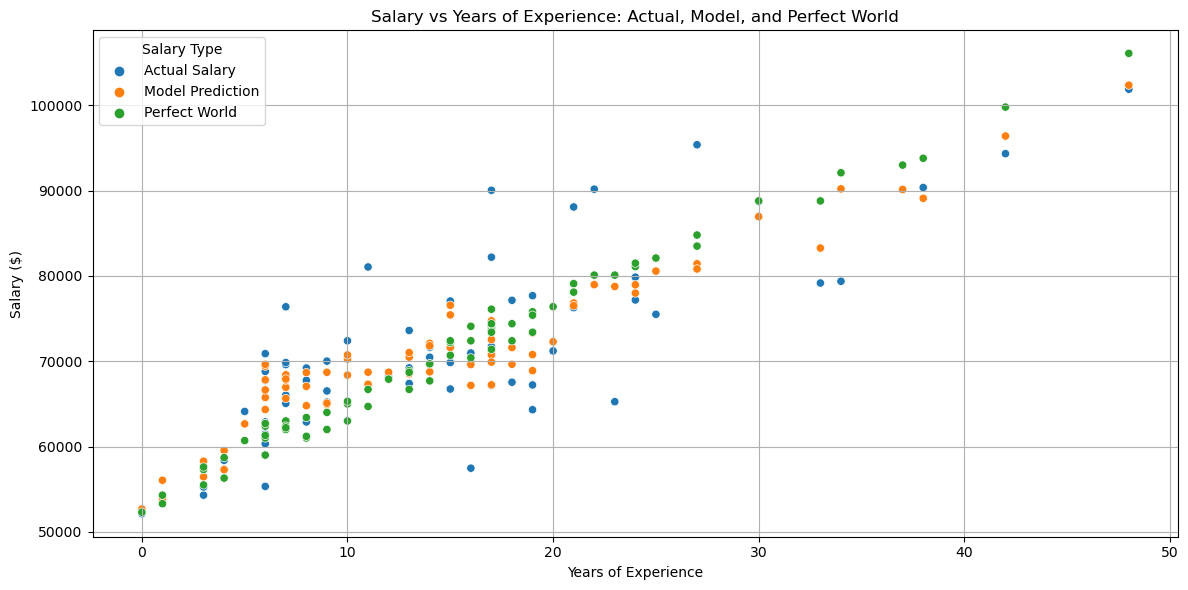

In [752]:
# -----------------------------
# Reshape for plotting
# -----------------------------
df_plot = df[[
    "Years of Exp",
    "25-26 Salary",
    "Prediction_from_clean_model",
    "Perfect World Salary"
]].copy()

df_plot = df_plot.rename(columns={
    "25-26 Salary": "Actual Salary",
    "Prediction_from_clean_model": "Model Prediction",
    "Perfect World Salary": "Perfect World"
})

# Melt to long-form for seaborn
df_long = df_plot.melt(
    id_vars="Years of Exp",
    var_name="Salary Type",
    value_name="Salary"
)

# Clean up infinities or NaNs
df_long = df_long.replace([np.inf, -np.inf], np.nan).dropna(subset=["Salary"])

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_long, x="Years of Exp", y="Salary", hue="Salary Type")

plt.title("Salary vs Years of Experience: Actual, Model, and Perfect World")
plt.xlabel("Years of Experience")
plt.ylabel("Salary ($)")
plt.grid(True)
plt.legend(title="Salary Type")
plt.tight_layout()
plt.show()

In [753]:
import plotly.express as px
import pandas as pd
import numpy as np

# Prepare the data (assumes df already exists and has the right columns)
df_plot = df[[
    "Employee",
    "Years of Exp",
    "25-26 Salary",
    "Prediction_from_clean_model",
    "Perfect World Salary"
]].copy()

df_plot = df_plot.rename(columns={
    "25-26 Salary": "Actual Salary",
    "Prediction_from_clean_model": "Model Prediction",
    "Perfect World Salary": "Perfect World"
})

# Melt to long format
df_long = df_plot.melt(
    id_vars=["Years of Exp", "Employee"],
    var_name="Salary Type",
    value_name="Salary"
)

# Clean up infinities or NaNs
df_long = df_long.replace([np.inf, -np.inf], np.nan).dropna(subset=["Salary"])

# Interactive plot with trendlines
fig = px.scatter(
    df_long,
    x="Years of Exp",
    y="Salary",
    color="Salary Type",
    # trendline="ols",
    hover_data=["Employee", "Salary", "Years of Exp"],
    title="Salary vs Years of Experience: Actual, Model, and Perfect World"
)

fig.update_layout(
    height=600,
    legend_title="Salary Type",
    xaxis_title="Years of Experience",
    yaxis_title="Salary ($)",
    hovermode="closest"
)

fig.show()